In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import os
 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

def my_plot(topk_ids, selected=None, new_id=None):
    count = Counter(topk_ids.flatten().tolist())
    sorted_counts = sorted(count.items(), key=lambda x: x[0])
    elements = [k for k, v in sorted_counts]
    values = [v for k, v in sorted_counts] 
    colors = [  'skyblue' for v in values]
    if selected != None:
        colors[selected] = 'red'
    if new_id!= None:
        colors[new_id] = 'red'
    # 绘制柱状图
    plt.figure(figsize=(8, 5))
    plt.bar(elements, values, color=colors)
    plt.title('Frequency of Each Element', fontsize=14)
    plt.xlabel('Element', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    for i, value in enumerate(values):
        plt.text(elements[i], value + 0.1, str(value), ha='center', va='bottom', fontsize=10)

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [4]:

from vllm.model_executor.layers.fused_moe.fused_moe import fused_experts_impl 
import transformers
from transformers import Qwen2MoeConfig 
import torch
import os

# 假设已经加载了 model
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "Qwen/Qwen1.5-MoE-A2.7B"
config = transformers.AutoConfig.from_pretrained("Qwen/Qwen1.5-MoE-A2.7B")


WORLD_SIZE =  4
TOKEN_NUM= 1000
workers = [dict() for _ in range(WORLD_SIZE)]
for i in range(0,len(workers)):
    workers[i]["world_size"] = WORLD_SIZE
    workers[i]["rank"] =   i
print(workers)
 


[{'world_size': 4, 'rank': 0}, {'world_size': 4, 'rank': 1}, {'world_size': 4, 'rank': 2}, {'world_size': 4, 'rank': 3}]


In [3]:
! docker build -t moe_expert ~/vllm_test_field/vllm/flask_docker_app/.

DEPRECATED: The legacy builder is deprecated and will be removed in a future release.
            Install the buildx component to build images with BuildKit:
            https://docs.docker.com/go/buildx/

Sending build context to Docker daemon    277kB
Step 1/7 : FROM nvidia/cuda:12.1.1-base-ubuntu22.04
 ---> 72d1c5868625
Step 2/7 : WORKDIR /app
 ---> Using cache
 ---> a83412ad1a8a
Step 3/7 : RUN apt-get update && apt-get install -y git python3 python3-pip python3-dev && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> 024bf909d6ed
Step 4/7 : RUN pip3 install -v flask
 ---> Using cache
 ---> 6101706050d4
Step 5/7 : RUN pip3 install -v vllm
 ---> Using cache
 ---> b8e07ac7f122
Step 6/7 : COPY expert.py /app
 ---> 781d6e292b6f
Step 7/7 : CMD ["python3", "./expert.py"]
 ---> Running in 369f45609737
 ---> Removed intermediate container 369f45609737
 ---> bc060bd04a89
Successfully built bc060bd04a89
Successfully tagged moe_expert:latest


In [5]:
# def init_rank_weight(world_size, config ):
#     expert_num = config.num_experts
#     avg_expert = expert_num // world_size
#     w13_weight = torch.nn.
#     (torch.randn(
#             avg_expert,
#             2 * config.moe_intermediate_size,
#         config.hidden_size,
#         dtype=torch.bfloat16), requires_grad=False).to("cuda")
#     print(w13_weight.shape)
#     w2_weight =torch.nn.Parameter(torch.randn(
#         avg_expert,
#         config.hidden_size,
#         config.moe_intermediate_size ,
#         dtype=torch.bfloat16),
#         requires_grad=False).to("cuda")
#     print(w2_weight.shape) 
#     return w13_weight, w2_weight

# for worker in workers:
#     worker["w1"] , worker["w2"] = init_rank_weight(WORLD_SIZE, config)
# ----------------------------------------original code above--------------------------------------

import subprocess
import time
import torch
# configs
torch.cuda.empty_cache()
torch.cuda.synchronize()
NUM_CONTAINERS = WORLD_SIZE
IMAGE_NAME = "moe_expert"
layer = 23
experts_count_per_container = 60//NUM_CONTAINERS

start_time = time.time() 

for i in range(NUM_CONTAINERS):
    cmd = [
    "docker", "run", "-d",
    "--name", f"fused_moe_layer_{layer}_exp_{i*experts_count_per_container}_{(i+1)*experts_count_per_container-1}",
    "--gpus", "all",
    "--rm",
    "-p", f"{5000+i}:5000",
    "-v", "/home/ubuntu/vllm_test_field/vllm/ipc_handler_demo/weights:/app/weights",
    "-e", f"RANK={i}",
    "-e", f"NUM_EXPERTS={experts_count_per_container}",
    "-e", f"GPU_IDX={i}",
    "-e", f"WEIGHT_PATH=/app/weights",
    "-e", f"LAYER={layer}",
    
    IMAGE_NAME
    ]
    try:
        subprocess.run(cmd, check=True)
        print(f"fused_moe_layer_{layer}_exp_{i*experts_count_per_container}_{(i+1)*experts_count_per_container-1}\n容器启动成功！")
    except subprocess.CalledProcessError as e:
        print(f"启动失败: {e}")
        

end_time = time.time()  # 记录结束时间
elapsed_time = end_time - start_time  # 计算用时
print(f"Containers launched in: {elapsed_time*1000:.2f} ms")
print(f"Average containers launching time : {elapsed_time*1000/WORLD_SIZE:.2f} ms")

3452dc6ce31c2cc90c6359f405998889d64fddac82715b80dc0d16e71af96a41
fused_moe_layer_23_exp_0_14
容器启动成功！
c54c2f30cf187f0599deb40fb89deb046152d7f20458f2b78801b5db22931ade
fused_moe_layer_23_exp_15_29
容器启动成功！
98744223b7048367f22d5f650bf0370fc6d1bfbf5e2d4ea601984161ba74c3dc
fused_moe_layer_23_exp_30_44
容器启动成功！
36008cdfdf45fe8a9f9304d3a407704aa825a18d0db019cdd5a0259c9a8cc7bc
fused_moe_layer_23_exp_45_59
容器启动成功！
Containers launched in: 2308.21 ms
Average containers launching time : 577.05 ms


In [6]:
def create_input(token_num, config):
    topk_ids = torch.randint(0, config.num_experts, (token_num, config.num_experts_per_tok), dtype=torch.int32).cpu()
    topk_weights = torch.randn(token_num, config.num_experts_per_tok, dtype=torch.float32).cpu()
    hidden_states = torch.randn( token_num, config.hidden_size, dtype=torch.bfloat16).cpu() # 
    print("topk_ids.shape", topk_ids.shape, topk_ids.dtype)
    print("topk_weights.shape", topk_weights.shape, topk_weights.dtype)
    print("hidden_states.shape", hidden_states.shape, hidden_states.dtype)
    return {"topk_ids":topk_ids.tolist(),"topk_weights":topk_weights.tolist(), "hidden_states":hidden_states.tolist() }

inputs = create_input( TOKEN_NUM, config)

topk_ids.shape torch.Size([1000, 4]) torch.int32
topk_weights.shape torch.Size([1000, 4]) torch.float32
hidden_states.shape torch.Size([1000, 2048]) torch.bfloat16


In [ ]:
# def init_expert_map(rank, world_size, total_expert_num):
#     avg_expert_num = total_expert_num // world_size
#     real_local_expert_ids = list(range(rank * avg_expert_num, (rank + 1) * avg_expert_num))
#     expert_map = [-1] * total_expert_num
#     for local_id, global_id in enumerate(real_local_expert_ids):
#         expert_map[global_id] = local_id
#     return torch.tensor(expert_map, device="cuda", dtype=torch.int32)

# for worker in workers:
#     worker["expert_map"]  = init_expert_map( worker["rank"],WORLD_SIZE,  config.num_experts)
#     print(worker["expert_map"], worker["expert_map"].shape)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1], device='cuda:0', dtype=torch.int32) torch.Size([60])
tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  1,  2,
         3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1], device='cuda:0', dtype=torch.int32) torch.Size([60])
tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  1,  2,  3,  4,  5,
         6,  7,  8,  9, 10, 11, 12, 13, 14, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1], device='cuda:0', dtype=torch.int32) torch.Size([60])
tensor([-1, -1, -1, -1

In [7]:
# def moe_forward(worker, inputs ):
#     output = fused_experts_impl(
#         hidden_states = inputs["hidden_states"],
#         w1 = worker["w1"],
#         w2 = worker["w2"],
#         topk_weights = inputs["topk_weights"],
#         topk_ids = inputs["topk_ids"],
#         inplace = True,
#         activation = "silu",
#         expert_map = worker["expert_map"],
#         global_num_experts =worker["expert_map"].shape[0]
#     )
#     return output

# for worker in workers:
#     worker["output"] = moe_forward (worker, inputs)
#     print(worker["output"].shape)
import requests
out_hidden_states = []
for i in range(WORLD_SIZE):
    url = f"http://localhost:500{i}/forward"
    response = requests.post(url, json=inputs)

    output = torch.tensor(response.json()["hidden_output"],dtype=torch.bfloat16,device="cuda:0")
    latency_ms = response.json()["latency_ms"]
    print(f"Container {i} latency: {latency_ms} ms")
    print("output.shape", output.shape)
    out_hidden_states.append(output)

Container 0 latency: 1545.190673828125 ms
output.shape torch.Size([1000, 2048])
Container 1 latency: 1541.0206298828125 ms
output.shape torch.Size([1000, 2048])
Container 2 latency: 1531.257080078125 ms
output.shape torch.Size([1000, 2048])
Container 3 latency: 1542.7398681640625 ms
output.shape torch.Size([1000, 2048])


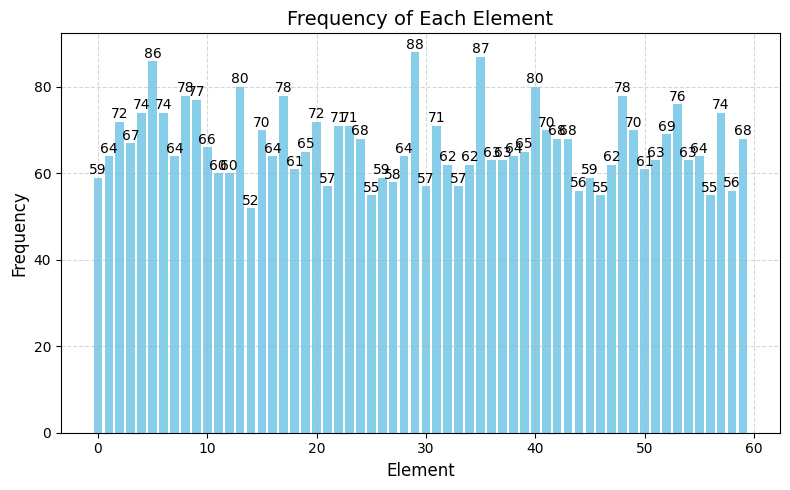

In [8]:
my_plot(torch.tensor(inputs["topk_ids"]))

Load balance

In [25]:


# def select_expert(topk_ids):
#     # return expert_id, max_token_num
#     count = Counter(topk_ids.flatten().tolist())
#     sorted_counts_cnt = sorted(count.items(), key=lambda x: x[1],reverse=True)
#     print(f"selected_id {sorted_counts_cnt[0][0]}, max_token_num { sorted_counts_cnt[0][1]}"  )
#     return sorted_counts_cnt[0][0], sorted_counts_cnt[0][1]
# selected_id, max_token_num = select_expert(inputs["topk_ids"])

# ----------------------------------------original code above--------------------------------------
def select_expert(topk_ids):
    # return expert_id, max_token_num
    counts = Counter(topk_ids.flatten().tolist())
    sorted_counts_cnt = sorted(counts.items(), key=lambda x: x[1],reverse=True)
    average =( sum(counts.values())+1) // len(counts.values())
    
    print(f"The average experts load is: {average}")

    exceeded_loads = {k: (v - average if v > average else 0) for k, v in sorted_counts_cnt}
    return exceeded_loads

exceeded_expert_load = select_expert(torch.tensor(inputs["topk_ids"]).cpu())
print("exceeded_expert_load: ", sorted(exceeded_expert_load.items(), key=lambda x: x[0],reverse=False))
print("total exceeded_expert_load: ", sum(exceeded_expert_load.values()))
print("max load in exceeded_expert_load: ", max(exceeded_expert_load.values()))


The average experts load is: 66
exceeded_expert_load:  [(0, 0), (1, 0), (2, 6), (3, 1), (4, 8), (5, 20), (6, 8), (7, 0), (8, 12), (9, 11), (10, 0), (11, 0), (12, 0), (13, 14), (14, 0), (15, 4), (16, 0), (17, 12), (18, 0), (19, 0), (20, 6), (21, 0), (22, 5), (23, 5), (24, 2), (25, 0), (26, 0), (27, 0), (28, 0), (29, 22), (30, 0), (31, 5), (32, 0), (33, 0), (34, 0), (35, 21), (36, 0), (37, 0), (38, 0), (39, 0), (40, 14), (41, 4), (42, 2), (43, 2), (44, 0), (45, 0), (46, 0), (47, 0), (48, 12), (49, 4), (50, 0), (51, 0), (52, 3), (53, 10), (54, 0), (55, 0), (56, 0), (57, 8), (58, 0), (59, 2)]
total exceeded_expert_load:  223
max load in exceeded_expert_load:  22


In [ ]:
# def get_new_map(rank, world_size, total_expert_num, selected_id):
#     avg_expert_num = total_expert_num // world_size
#     real_local_expert_ids = list(range(rank * avg_expert_num, (rank + 1) * avg_expert_num))
#     expert_map = [-1] * (total_expert_num+1)
#     for local_id, global_id in enumerate(real_local_expert_ids):
#         expert_map[global_id] = local_id
#     if selected_id in real_local_expert_ids:
#         expert_map[-1] =  len(real_local_expert_ids)
#     return torch.tensor(expert_map, device="cuda", dtype=torch.int32)

# for i in range(0,WORLD_SIZE):
#     new_expert_map  = get_new_map(
#         i,WORLD_SIZE,config.num_experts, selected_id
#     )
#     workers[i]["new_expert_map"] = new_expert_map
#     print(new_expert_map, new_expert_map.shape)
def get_new_map():
    exps=[[-1]*120 for _ in range(5)]
    original_map=list(range(0,15))
    for i in range(0,4):
        exps[i][i*15:(i+1)*15]=original_map
    exps[-1][-60:]=list(range(0,60))
    return exps
new_expert_maps=

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1

In [10]:
def get_new_weight( w1,w2, rank,  selected_id, expert_map ):
    local_idx = expert_map [selected_id]
    if local_idx == -1:
        print(f"[Rank {rank}]: Selected expert {selected_id} not in local expert_map. Skip.")
        return w1, w2
    else:
        # replicate expert
        print(f"[Rank {rank}]: Replicating expert {selected_id}, local_idx: {local_idx}")
        # extract and append the expert weights
        new_expert_w1 = w1[local_idx].unsqueeze(0)  
        new_expert_w2 = w2[local_idx].unsqueeze(0)
        # concat new expert w1 to w1
        new_w1 = torch.cat((w1, new_expert_w1.to(w1.device)), dim=0)
        new_w2 = torch.cat((w2, new_expert_w2.to(w2.device)), dim=0)
        print(f"[Rank {rank}]: New w1 shape: {new_w1.shape}")
        print(f"[Rank {rank}]: New w2 shape: {new_w2.shape}")
        return new_w1, new_w2
for i in range(0,WORLD_SIZE):
    new_w1, new_w2 = get_new_weight(
        workers[i]["w1"],
        workers[i]["w2"],
        i,
        selected_id,
        workers[i]["new_expert_map"]
    )
    workers[i]["new_w1"] = new_w1
    workers[i]["new_w2"] = new_w2

[Rank 0]: Selected expert 53 not in local expert_map. Skip.
[Rank 1]: Selected expert 53 not in local expert_map. Skip.
[Rank 2]: Selected expert 53 not in local expert_map. Skip.
[Rank 3]: Replicating expert 53, local_idx: 8
[Rank 3]: New w1 shape: torch.Size([16, 2816, 2048])
[Rank 3]: New w2 shape: torch.Size([16, 2048, 1408])


In [11]:
def modify_topk_ids(topk_ids, selected_id, token_num, expert_num):
    topk_ids = topk_ids.clone()
    # 将一半 selected_id 的 workload 转移给新 expert
    cnt = 0
    new_expert_id = expert_num
    for i in range(topk_ids.shape[0]):
        for j in range(topk_ids.shape[1]):
            if topk_ids[i][j] == selected_id:
                topk_ids[i][j] = new_expert_id
                print(f"{selected_id} -> {new_expert_id}")
                cnt += 1
                if cnt >= token_num // 2:
                    break
        if cnt >= token_num // 2:
            break

    return topk_ids, new_expert_id

inputs["new_topk_ids"] ,new_expert_id= modify_topk_ids(inputs["topk_ids"],selected_id,max_token_num, config.num_experts )

53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60
53 -> 60


In [12]:
def new_moe_forward(worker, inputs ):
    output = fused_experts_impl(
        hidden_states = inputs["hidden_states"],
        w1 = worker["new_w1"],
        w2 = worker["new_w1"],
        topk_weights = inputs["topk_weights"],
        topk_ids = inputs["new_topk_ids"],
        inplace = True,
        activation = "silu",
        expert_map =worker["new_expert_map"]  ,
        global_num_experts =worker["new_expert_map"].shape[0]
    )
    return output
for worker in workers:
    worker["new_output"] = new_moe_forward (worker, inputs)
    print(worker["new_output"].shape)

WARNING 04-26 16:24:12 [fused_moe.py:881] Using default MoE config. Performance might be sub-optimal! Config file not found at /opt/conda/envs/vllm082/lib/python3.12/site-packages/vllm/model_executor/layers/fused_moe/configs/E=15,N=2048,device_name=NVIDIA_GeForce_RTX_4090.json
torch.Size([1000, 2048])
torch.Size([1000, 2048])
torch.Size([1000, 2048])
WARNING 04-26 16:24:12 [fused_moe.py:881] Using default MoE config. Performance might be sub-optimal! Config file not found at /opt/conda/envs/vllm082/lib/python3.12/site-packages/vllm/model_executor/layers/fused_moe/configs/E=16,N=2048,device_name=NVIDIA_GeForce_RTX_4090.json
torch.Size([1000, 2048])


In [13]:
for i in workers:
    print(torch.equal(
        i["new_output"], i["output"]
    ))

True
True
True
True


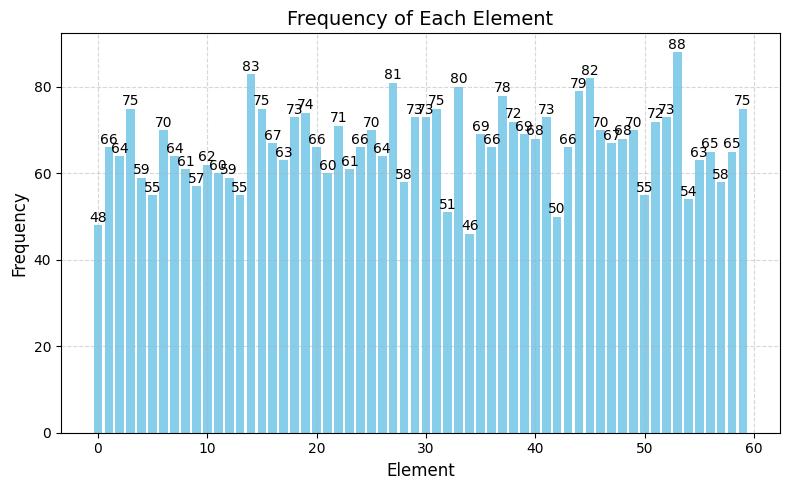

selected_id 53


In [14]:
my_plot(inputs["topk_ids"] )
print("selected_id", selected_id)

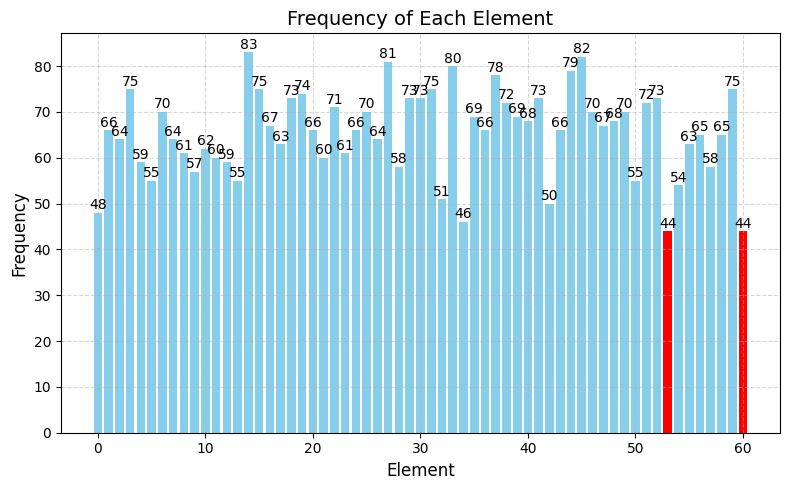

selected_id 53 new_expert_id 60


In [15]:
my_plot(inputs["new_topk_ids"], selected_id, new_expert_id)
print("selected_id", selected_id, "new_expert_id", new_expert_id)

In [16]:
# test_time
import time
selected_rank  = selected_id // (config.num_experts // WORLD_SIZE)
print(selected_rank)
before_time_list = []
cnt = 20
for i in range(cnt):
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    start_event.record()
    moe_forward (workers[selected_rank], inputs)
    end_event.record()
    torch.cuda.synchronize()
    latency_ms = start_event.elapsed_time(end_event)
    before_time_list.append(latency_ms)
    
print(before_time_list)
print(len(before_time_list))
print(sum(before_time_list)/ len(before_time_list))

3
[1.8649920225143433, 0.8212479948997498, 0.738207995891571, 0.7362560033798218, 0.7157760262489319, 0.7208960056304932, 0.7219200134277344, 0.7331839799880981, 0.6983680129051208, 0.6993920207023621, 0.6973119974136353, 0.6952959895133972, 0.7055360078811646, 0.711679995059967, 0.711679995059967, 0.6962239742279053, 0.693343997001648, 0.6983680129051208, 0.7280319929122925, 0.7137280106544495]
20
0.7750720024108887


In [17]:
after_time_list = []
for i in range(cnt):
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True) 
    start_event.record()
    new_moe_forward (workers[selected_rank], inputs)
    end_event.record()
    torch.cuda.synchronize()
    latency_ms = start_event.elapsed_time(end_event)
    after_time_list.append(latency_ms)
print(after_time_list)
print(len(after_time_list))
print(sum(after_time_list)/ len(after_time_list))

[1.6424959897994995, 0.9041919708251953, 0.8734719753265381, 0.8499199748039246, 0.8417279720306396, 0.8458240032196045, 0.8775680065155029, 0.8734719753265381, 0.8723840117454529, 0.8734719753265381, 0.8775680065155029, 0.869376003742218, 0.8704000115394592, 0.8703039884567261, 0.8724480271339417, 0.8724799752235413, 0.8704000115394592, 0.8673279881477356, 0.8692799806594849, 0.8795199990272522]
20
0.9086815923452377
